In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ROOT = Path.cwd()
SAC_RUNS_DIR = ROOT / '..' / 'results' / 'sac_runs'
NOISE_TYPES = ['normal', 'pink', 'red']

def pick_noise_run(noise: str) -> Path:
    candidates = sorted(
        [d for d in SAC_RUNS_DIR.iterdir() if d.is_dir() and d.name.endswith(f'-{noise}')],
        key=lambda p: p.name
    )
    if not candidates:
        raise FileNotFoundError(f'No run directory found for noise suffix -{noise}')
    return candidates[-1]

def first_match(folder: Path, pattern: str) -> Path:
    matches = sorted(folder.glob(pattern))
    if not matches:
        raise FileNotFoundError(f'No file matching {pattern} in {folder}')
    return matches[0]

series = {}
for noise in NOISE_TYPES:
    run_dir = pick_noise_run(noise)
    csv_dir = run_dir / 'csvs'

    episode_logs = pd.read_csv(first_match(csv_dir, '*episode_logs.csv'))
    winrates = pd.read_csv(first_match(csv_dir, '*winrates.csv'))

    series[noise] = {
        'episodes': episode_logs['episode'].to_numpy(),
        'rewards': episode_logs['reward'].to_numpy(),
        'steps': winrates['step'].to_numpy(),
        'winrates': winrates['winrate'].to_numpy(),
    }

In [3]:
series["normal"]["winrates"][-1] = 0.87

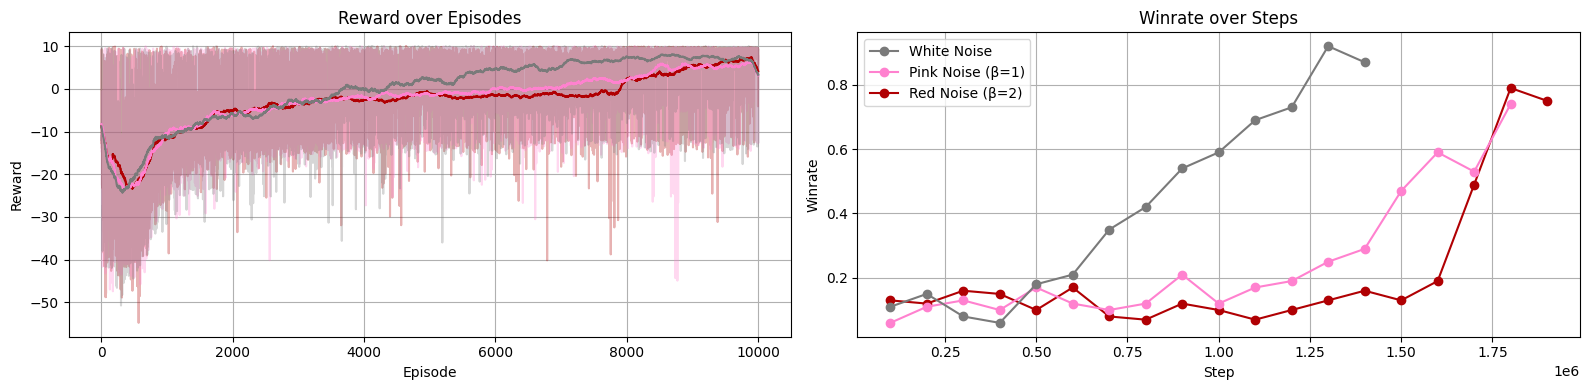

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

colors = {'normal': "#7A7A7A", 'pink': "#ff81cf", 'red': "#b00003"}
labels = {'normal': 'White Noise', 'pink': 'Pink Noise (β=1)', 'red': 'Red Noise (β=2)'}

window = np.ones(200) / 200

for noise in reversed(NOISE_TYPES):
    s = series[noise]
    axes[0].plot(s['episodes'], s['rewards'], color=colors[noise], alpha=0.3)
    axes[0].plot(s['episodes'], np.convolve(s['rewards'], window, mode='same'), label=labels[noise], color=colors[noise], zorder=3)
    axes[1].plot(s['steps'], s['winrates'], label=labels[noise], marker='o', color=colors[noise])

axes[0].set_title('Reward over Episodes')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Reward')
axes[0].grid(True)

axes[1].set_title('Winrate over Steps')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Winrate')
axes[1].grid(True)
axes[1].legend()

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1], labels[::-1])

plt.tight_layout()
plt.show()